TODOs:
- Gas Prices per Weekday and Hour
- Remove trends

In [1]:
import pandas as pd
import os
import aioinflux
import calendar

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline  

In [2]:
kwargs = {
    'host': '192.168.2.131',
    'port': os.getenv('INFLUXDB_PORT'),
    'username': os.getenv('INFLUXDB_USER'),
    'password': os.getenv('INFLUXDB_PASS'),
    'db': os.getenv('INFLUXDB_DB'),
    'output': 'dataframe'
}

measurement = 'gas_prices_euro'
async with aioinflux.InfluxDBClient(**kwargs) as ifclient:
    df = await ifclient.query(f"""
        SELECT * FROM {measurement}
    """)

In [3]:
brand = 'Star'
gas_type = 'e5'
metric = df[df['brand']==brand][gas_type]

In [4]:
def plot_gas_prices(df_quantiles, index=None, title_post_fix=''):
    if index is None:
        index = df_quantiles.index
    fig, ax = plt.subplots()
    ax.fill_between(
        index, df_quantiles[0.5], df_quantiles[0.95], alpha=0.4, edgecolor='black', facecolor='blue'
    )
    ax.fill_between(
        index, df_quantiles[0.05], df_quantiles[0.5], alpha=0.4, edgecolor='black', facecolor='blue'
    )

    #grid
    plt.rc('grid', linestyle="dotted", color='black')
    plt.grid(True)

    # set labels
    plt.title(f'Gas Price ({gas_type.capitalize()}) {title_post_fix}')
    plt.ylabel(f'Gas Price (in Euro)');

    return fig, ax

In [5]:
def compute_quantiles(metric, grouper):
    df = metric.groupby(grouper).quantile([0.05, 0.5, 0.95])
    return df.reset_index().pivot(index='level_0', columns='level_1', values=[gas_type])

## Gas Prices per Week

In [6]:
df_week_summary = compute_quantiles(metric, pd.Grouper(freq='W-MON'))

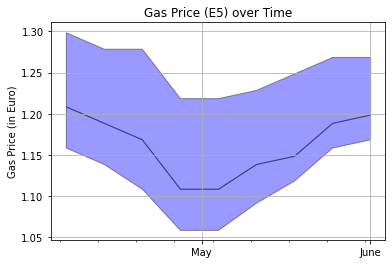

In [7]:
fig, ax = plot_gas_prices(df_week_summary[gas_type], title_post_fix='over Time')
# format the ticks
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%B'))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=7));

#plt.savefig(f'{metric}.png', dpi=300)

## Gas Prices per Weekday

In [8]:
weekday_map = dict(enumerate(calendar.day_name))

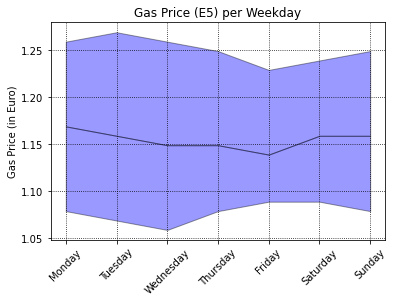

In [9]:
df_weekday_summary = compute_quantiles(metric, metric.index.dayofweek)
fig, ax = plot_gas_prices(
    df_weekday_summary[gas_type],
    index=df_weekday_summary.index.map(weekday_map),
    title_post_fix='per Weekday'
)
# format the ticks
plt.xticks(rotation=45);

## Hourly Gas Prices

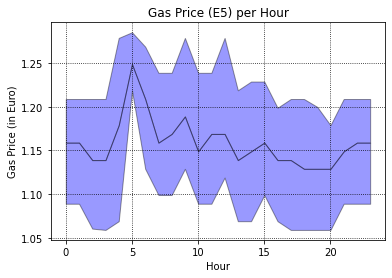

In [10]:
df_hour_summary = compute_quantiles(metric, metric.index.hour)

fig, ax = plot_gas_prices(df_hour_summary[gas_type], title_post_fix='per Hour')
ax.set_xlabel('Hour');
#plt.savefig(f'{metric}.png', dpi=300)